# Sentiment Analysis

## 02. Feedforward Neural Network

In this notebook, I will explore and implement a Feedforward Neural Network model for sentiment classification.

In [27]:
# Pytorch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics.functional import f1_score

# Nltk for tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Math, String, etc
from copy import deepcopy
import sys
import re
import os
import string
import time
import datetime
import random
import math

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn
import optuna
from optuna.trial import TrialState
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

Below is the Dataset ingestion and labeling of the classifications. I will be splitting the data into train, validation for control and test set.

In [22]:
# Using \t as delimeter and reading with pandas 
df = pd.read_csv("./imdb-reviews.csv", sep = '\t')
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# I will reserve 8% of the samples for testing and 10% for validation to be used while tuning
train_X, val_X, test_X = X[:int(len(X)*0.82)], X[int(len(X)*0.82):int(len(X)*0.92)], X[int(len(X)*0.92):]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.82)], Y[int(len(Y)*0.82):int(len(Y)*0.92)], Y[int(len(Y)*0.92):]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

len(train_X), len(val_X), len(test_X), len(train_X)+len(val_X)+len(test_X)

(36906, 4501, 3601, 45008)

Defining a Dataset class to be used for the dataloaders.

In [23]:
# A custom Dataset class to use for the dataloaders
class customDataset(Dataset):

    def __init__(self, xdata, ydata):
        self.x = torch.from_numpy(xdata)
        self.y = torch.from_numpy(ydata)
        self.samples = ydata.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Tokenizer and GloVe Embeddings

Downloading the GloVe embeddings from Stanford.

In [ ]:
# Download glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In the cell below are helper functions for preprocessing.

- In `dict_push` a GloVe file is read and each word of it is added in a dictionary with its corresponding vector.

- Since I'm working with GloVe embeddings a Stemmer that reduces words to their stems wouldn't find many matches in GloVe, so I chose to use the `LemmatizingTokenizer` class and `pos_wordnet` function I built for the previous homework. I simply added a final layer of removing words that are not present in the word dictionary of GloVe.

- The function `token_vectors` tokenizes a review using the Lemmatizer and adds the corresponding vectors for each word. While `prepare_data` transforms the data into these word vectors.

In [5]:
# Builds word dictionary
def dict_push(dict, file):
    with open(file, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')
            # Add the vector in the dictionary
            dict[line[0]] = np.array(line[1:], dtype=float)

# Returns equivalent wordnet pos
def pos_wordnet(tag):
    if tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatizes using wordnet and also removes stopwords
class LemmatizingTokenizer:
    def __init__(self, word_dict) -> None:
        self.wnl = WordNetLemmatizer()
        self.word_dictionary = word_dict
    def __call__(self, review):
        tokens = nltk.word_tokenize(review)
        # make all of them lowercase
        tokens = [token.lower() for token in tokens]
         # Keep a list of the stop words from NLTK
        stopwords_list = stopwords.words('english') 
        # List of words without stopwords or punctuation
        words = []
        for token in tokens:
            if token not in stopwords_list and token not in string.punctuation:
                words.append(token)
        tokens_tagged = nltk.pos_tag(words)
        all_words = [self.wnl.lemmatize(token, pos=pos_wordnet(tag)) for token, tag in tokens_tagged]
        # Keeping only the ones that appear in Glove
        words_in_glove = [word for word in all_words if word in self.word_dictionary]
        return words_in_glove

# Tokenizes a review and adds the corresponding vectors
def token_vectors(review, word_dictionary):
    tokenizer = LemmatizingTokenizer(word_dictionary)
    tokens = tokenizer(review)
    token_vectors = []
    for token in tokens:
        token_vectors.append(word_dictionary[token])
    return np.array(token_vectors, dtype=float)

# Turns the sentences into vector embeddings
def prepare_data(X, word_dictionary):
    vectors = []
    for review in X:
        review_vector = token_vectors(review, word_dictionary)
        vectors.append(review_vector)
    return vectors

## Embeddings Vector Techniques

Investigating on how to use these vector embeddings on a Feedforward Network, I found two techniques. One was using all the vectors of each word, and the other was taking the sum or average of these vectors. Before working on finetuning the neural network itself, I'll define a trivial neural network and explore these two techniques.

In terms of the Embedding layer, though PyTorch provides one, I chose to perform this preparation with custom functions to familiarize myself with how it works and to have more control over what is passed to the sequential layer.

### Padding Approach

Initially, I'll use the vectors of each word. I define the `add_padding` function below, which retains only a maximum length of words for each review. If it's below that threshold, the rest of the vectors are padded with zeroes to ensure equal length.

In [6]:
# Function that padds all tokens to be equal length and return numpy array
def add_padding(X, max_length, dim):
    X_new =deepcopy(X)
    for i, vector in enumerate(X):
        if vector.shape[0]<max_length:
            padding = np.zeros(shape=(max_length-vector.shape[0], dim))
            X_new[i] = np.concatenate([vector, padding])
        elif vector.shape[0]==max_length:
            X_new[i] = np.array(vector)
        else:
            X_new[i] = np.array(vector[:max_length])
    return np.array(X_new).astype(float)

I will use the 100 dimensional data from GloVe and keeping as maximum the first hundred words of each review. Since in my lemmatizing tokenizer the stopwords are removed as well as the words that are not present in the dictionary, there will be a good representation of the sentiment even in the first part of a large review.

In [9]:
# Creating the 100 dimensional dictionary
word_dictionary_100d = dict()
dict_push(word_dictionary_100d, 'glove.6B.100d.txt')

# Preparing the train validation and test data respectively
X_train = prepare_data(train_X, word_dictionary=word_dictionary_100d)
X_train_padded = add_padding(X_train, 100, 100)
X_val = prepare_data(val_X, word_dictionary=word_dictionary_100d)
X_val_padded = add_padding(X_val, 100, 100)
X_test = prepare_data(test_X, word_dictionary=word_dictionary_100d)
X_test_padded = add_padding(X_test, 100, 100)

Since PyTorch is used, I assume that the datasets have been initialized and loaded into dataloaders. The dataloaders will have a batch size of 512 to accommodate the large data size. For the Test dataloader, the shuffle parameter is set to False.

In [10]:
# Datasets
trainDataset = customDataset(X_train_padded, indexed_labels_train)
valDataset = customDataset(X_val_padded, indexed_labels_val)
testDataset = customDataset(X_test_padded, indexed_labels_test)

# Corresponding dataloaders
train_dataloader = DataLoader(dataset=trainDataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(dataset=valDataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(dataset=testDataset, batch_size=512, shuffle=False)

#### Network Training

- The function `trainEpoch` trains a Neural Network for one epoch and calculates the loss for each batch and informs the weights. With the display boolean as true it also prints the loss with a rate of your choosing.

- Then `trainNetwork` simply trains a network till a number of epochs is reached and returns the model. Both functions take as arguments the optimizer, dataloader, loss function and device in case the GPU is used.

In [80]:
# Function to train for one epoch
def trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display=True):

    losses = []

    # For each batch
    for batch, (x, y) in enumerate(dataloader):

        x = x.float()

        # In case the GPU is used
        x = x.to(device)
        y = y.to(device)
        
        # Predict and calculate loss
        prediction = neuralnetwork(x)
        loss = lossfunc(prediction, y)
        losses.append(loss.item())

        # Inform the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(x)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    meanloss = 0
    if len(losses)!=0:
        # The total mean loss
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a network
def trainNetwork(epochs, optimizer, dataloader, lossfunc, neuralnetwork, device, display=True):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display)
        if (display):
            print("_________________________________")
        
    # Returns the neural network
    return neuralnetwork

#### Evaluation Function

- The `evaluationFunction` passes the batches of the dataloader in the arguments through the model making predictions without informing the weights. It calculates and returns precision, recall and F1 macro averaged score, as well as the accuracy and mean loss. 

- The predictions as well as the true values are returned so that I can plot the confusion matrix later on. Also, I return the probabilities of the positive class, when I'm plotting the ROC curve since this is needed.

In [79]:
# Evaluation function
def evaluationFunction(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():
        
        for (x,y) in dataloader:
            x = x.float()
            x = x.to(device)
            y = y.to(device)

            # Make predictions
            scores = model(x)
            _, predictions = scores.max(1)

            # Probability estimates of the positive class
            y_probs = torch.abs(scores[:,1].cpu())
            
            # Loss
            loss = lossfunc(scores, y).item()
            losses.append(loss)

            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            y=y.cpu()
            probs.extend(y_probs.numpy())
            preds.extend(predictions.numpy())
            trues.extend(y.numpy())
            correctCount += (predictions==y).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(preds=torch.tensor(preds), target=torch.tensor(trues), average="macro", num_classes=4).item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

Below are the functions for the plotting of the Confusion Matrix and ROC curve. The `rocCurve` function also calculates the roc auc score using the sklearn function and returns it as well.

In [13]:
# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    seaborn.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.style.use('seaborn')
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

#### Feedforward Neural Network

Below, I'll define a simple neural network to test the two approaches. Later on, I'll experiment with activation functions, dropout, and tuning the hyperparameters. However, for now, I'll keep it simple to compare the two techniques.

I'll use a Sequential container with three linear layers and a sigmoid at the end, to obtain the probabilities for the ROC curves. Since the embedding is handled by the helper functions that preprocess the reviews and produce the vectors, there won't be an initial Embedding layer.

In [14]:
# Feedforward Neural Network
class FeedforwardNeuralNetwork(nn.Module):
    
    def __init__(self, count, dim_embed):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(count*dim_embed, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 2),
            nn.Sigmoid()
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

Initially training the Neural Network with the padded vector embeddings I declared above and then evaluating on the test set. Please note that the device will be set to Apple Silicon first, but it will fall back to CUDA if you run the notebook online and to CPU if you haven't activated the GPU.

Here are the training details:

- Optimizer: Stochastic Gradient Descent
- Learning rate: 0.02
- Loss function: Cross-entropy loss
- Epochs: 20


Epoch 1
_________________________________
loss: 0.692314  [    0/36906]
loss: 0.690756  [32768/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.688710  [    0/36906]
loss: 0.685446  [32768/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.685627  [    0/36906]
loss: 0.681383  [32768/36906]
_________________________________

Epoch 4
_________________________________
loss: 0.678208  [    0/36906]
loss: 0.671136  [32768/36906]
_________________________________

Epoch 5
_________________________________
loss: 0.672410  [    0/36906]
loss: 0.665498  [32768/36906]
_________________________________

Epoch 6
_________________________________
loss: 0.663620  [    0/36906]
loss: 0.651495  [32768/36906]
_________________________________

Epoch 7
_________________________________
loss: 0.647557  [    0/36906]
loss: 0.642501  [32768/36906]
_________________________________

Epoch 8
________________________________

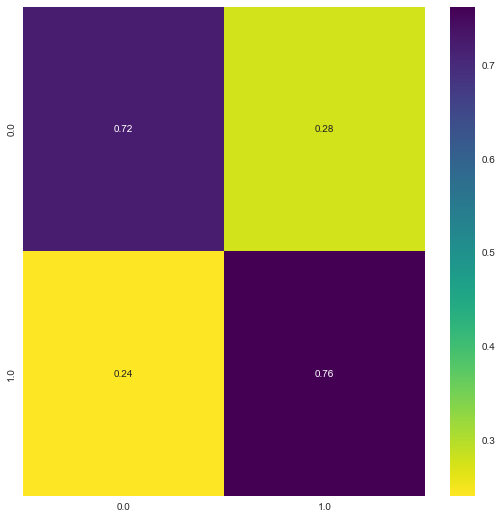

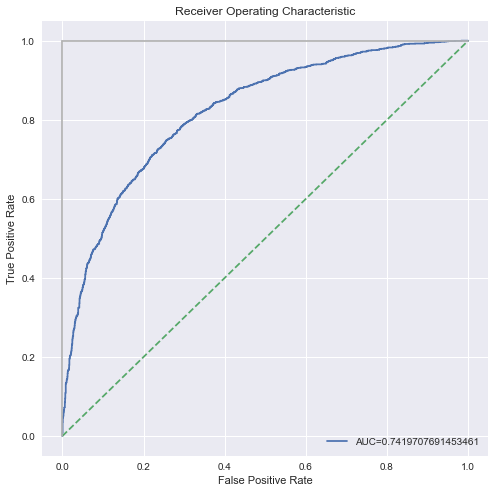

In [17]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

# To be able to compare times
startTime = time.time()

# Hyperparameters
epochs= 20
learning_rate = 2e-2
dataloader= train_dataloader

# Model initialisation and Training
model = FeedforwardNeuralNetwork(X_train_padded.shape[1], 100).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, dataloader, lossfunc, model, device)

# Print the time it took
endTime = time.time()
trainingTime = endTime - startTime
print(f"Total Training Time: {trainingTime:.2f}")

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

After the initial training, it seems that the Neural Network is performing quite well even with these naive hyperparameters and 100-dimensional embeddings. The metrics are all around 74%, and from the ROC curve, which is close to the top-left corner and the area under the curve (AUC), it is evident that the model is effective in distinguishing between the two classes. The total running time was 37 seconds.

### Mean Approach

Now, I will explore the mean technique, as explained in the paper: https://aclanthology.org/P16-1089.pdf by averaging the word vectors to obtain "review" level vectors. Although I experimented with summing the vectors alone, I will present only the experiments with averaging the vectors as it performed much better.

This approach makes sense because the magnitude in the vector space can be much larger for reviews with a lot of words, but this doesn't necessarily impact the sentiment of a review, which is what we are classifying. Reviews with few words may share the same sentiment as longer reviews, so it makes sense to average the vectors to have a similar dimension space. In the function below, I calculate the mean vector for each review.

In [18]:
def sentence_vectors(X, dim):
    X_new = np.zeros(shape=(len(X), dim)).astype(float)
    for i, vectors in enumerate(X):
        vec = np.zeros(shape=(1, dim)).astype(float)
        count = 0
        for vector in vectors:
            vec += np.array(vector).astype(float)
            count+=1
        X_new[i] = vec / count
    return X_new

Then I'm using this function to create one vector with the 300 dimensional embeddings for each review.

In [19]:
# Creating the 300 dimensional dictionary
word_dictionary_300d = dict()
dict_push(word_dictionary_300d, 'glove.6B.300d.txt')

# Preparing the train validation and test data respectively
X_train = prepare_data(train_X, word_dictionary=word_dictionary_300d)
X_train_means = sentence_vectors(X_train, 300)
X_val = prepare_data(val_X, word_dictionary=word_dictionary_300d)
X_val_means = sentence_vectors(X_val, 300)
X_test = prepare_data(test_X, word_dictionary=word_dictionary_300d)
X_test_means = sentence_vectors(X_test, 300)

Then creating the dataset and dataloaders with batch size 512 as before.

In [20]:
# Datasets
train_dataset = customDataset(X_train_means, indexed_labels_train)
val_dataset = customDataset(X_val_means, indexed_labels_val)
test_dataset = customDataset(X_test_means, indexed_labels_test)

# Corresponding dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

Finally training the model with the same settings, with the only difference here being the input of the sequential layer.


Epoch 1
_________________________________
loss: 0.693543  [    0/36906]
loss: 0.692759  [32768/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.692524  [    0/36906]
loss: 0.692769  [32768/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.692759  [    0/36906]
loss: 0.692308  [32768/36906]
_________________________________

Epoch 4
_________________________________
loss: 0.692550  [    0/36906]
loss: 0.692230  [32768/36906]
_________________________________

Epoch 5
_________________________________
loss: 0.692161  [    0/36906]
loss: 0.692254  [32768/36906]
_________________________________

Epoch 6
_________________________________
loss: 0.692075  [    0/36906]
loss: 0.691783  [32768/36906]
_________________________________

Epoch 7
_________________________________
loss: 0.691947  [    0/36906]
loss: 0.691373  [32768/36906]
_________________________________

Epoch 8
________________________________

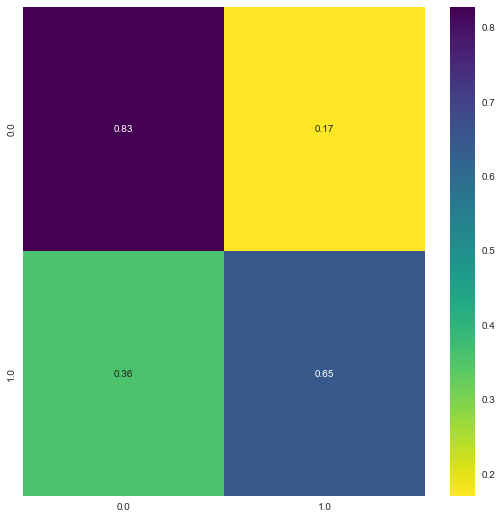

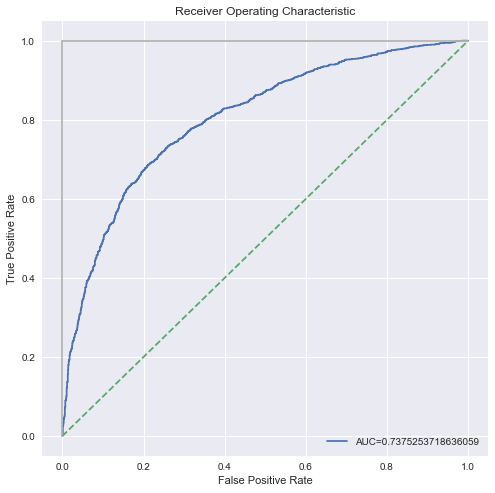

In [21]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

# To be able to compare times
startTime = time.time()

# Hyperparameters
epochs= 20
learning_rate = 2e-2
dataloader= train_dataloader

# Model initialisation and Training here 1 since it's only one vector and 300 dimension
model = FeedforwardNeuralNetwork(1, 300).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, dataloader, lossfunc, model, device)

# Print the time it took
endTime = time.time()
trainingTime = endTime - startTime
print(f"Total Training Time: {trainingTime:.2f}")

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The metrics for the mean approach are similar to the previous approach, with only a slight difference in recall and a marginal decrease in the area under the ROC curve. The notable advantage is that the execution time is three times faster due to the smaller size of the data.

This implies that if the allowed length of words in the padded approach or the dimension of the embeddings were larger, the execution time would be even longer. Since the mean approach performs similarly well and effectively represents the sentiment of a review, I will be using this approach in my subsequent experiments of this architecture.

## Automating Optimal Model Search & Learning Curves

To automate the process of finding the optimal model during training, I'll define below a function that trains for a specific number of epochs and saves the model (so that it can be loaded later for testing) with the best F1-macro averaged score. It also plots learning curves of the train versus the validation mean loss during each epoch.

In [95]:
# Function automating finding best model
def optimalModel(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False, scheduler=None):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, recall, precision = evaluationFunction(valdataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " validation loss: ", meanlossval, " and accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestModel.pt')
            torch.save(optimizer.state_dict(), './bestOptimizer.pt')
            if(scheduler):
                torch.save(scheduler.state_dict(), './bestScheduler.pt')
    
        if(display):
            print("__________________________________")
        
        # If there is a scheduler step here
        if (scheduler):
            if (scheduler.__class__.__name__=='ReduceLROnPlateau'):
                scheduler.step(meanloss)
            else:
                scheduler.step()

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.style.use('seaborn')
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch

### Reproducibility

During training and evaluation of the models it is crucial for the conditions to be deterministic so the `seedTorch` function below will be used.

In [60]:
# Seed function
def seedTorch(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

#### Testing Optimal Model

To trial the optimalModel function I define below the second Feedforward Network which is the same as before, with the added ReLU activation functions in its architecture.

In [90]:
# Feedforward Neural Network
class FeedforwardNeuralNetwork2(nn.Module):
    
    def __init__(self, count, dim_embed):
        super(FeedforwardNeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(count*dim_embed, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

Training this model for 30 epochs with `optimalModel` and then using the best model that is been saved to make the predictions on the test set. Then printing the metrics as well as the learning curve.

Training loss - validation loss average difference:  0.005436418800109644


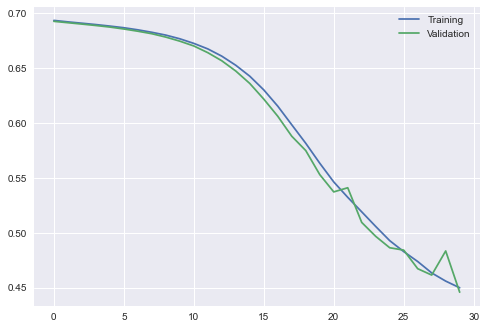

Best F1 score after  29  epochs.

Evaluation Results
_________________________________
Predicted 2898 / 3601 correctly
Mean Loss: 0.43 
Recall: 77.95%
Precision: 82.18%
Accuracy: 80.48%
Macro Averaged F1-score: 80.47%
_________________________________


In [97]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

seedTorch()

# Hyperparameters
epochs= 30
learning_rate = 2e-2
dataloader= train_dataloader

# Model initialisation and Training here 1 since it's only one vector and 300 dimension
model = FeedforwardNeuralNetwork2(1, 300).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
best_epoch = optimalModel(device, model, epochs, dataloader, val_dataloader, optimizer, lossfunc)

print("Best F1 score after ", best_epoch, " epochs.")

# Initialise and load the model with the best performance
seedTorch()
model = FeedforwardNeuralNetwork2(1, 300).to(device)
model.load_state_dict(torch.load('./bestModel.pt'))
model = model.to(device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)

The model performs already much better with the activation functions between the linear layers. From the learning curve it is obvious that up to a point the distance of the mean loss between train and validation is quite small. Later on they diverge a little bit, but it's still constistent and it doesn't overfit or underfit. While the best model was found after 29 epochs and using that the model predicts with an F1-score of 80% which is a good start.

### Activation Functions

To generalize the neural network before tuning the hyperparameters I'll trial the seven activation functions that are more suited for this Network. So again I'll use a similar network as before, but modifying the activation functions.

In [98]:
# Feedforward Neural Network with custom activation function
class FeedforwardNeuralNetwork3(nn.Module):
    
    def __init__(self, activation_function):
        super(FeedforwardNeuralNetwork3, self).__init__()
        self.flatten = nn.Flatten()
        self.activation_function = activation_function
        self.linear_stack = nn.Sequential(
            nn.Linear(300, 256),
            self.activation_function(),
            nn.Linear(256, 32),
            self.activation_function(),
            nn.Linear(32, 2)
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

Below I'll test these activation functions by training the model and then with the best performing one evaluate on the test set. Before each test of course I'll be seeding to have the same conditions. After each test I'll be printing the metrics and the learning curves and finally all the results together on a panda dataframe for comparison.

Training loss - validation loss average difference:  2.0792501218299304e-05


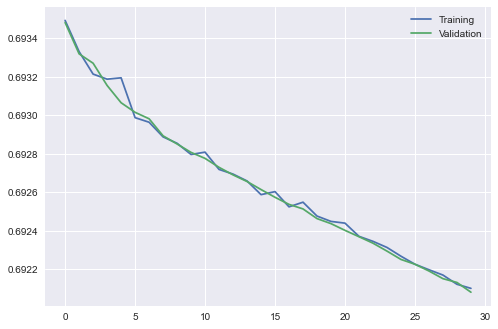


 ReLU  achieved best F1 score after  29  epochs.

Evaluation Results
_________________________________
Predicted 2193 / 3601 correctly
Mean Loss: 0.69 
Recall: 81.77%
Precision: 57.77%
Accuracy: 60.90%
Macro Averaged F1-score: 59.08%
_________________________________
Training loss - validation loss average difference:  2.079491745936209e-05


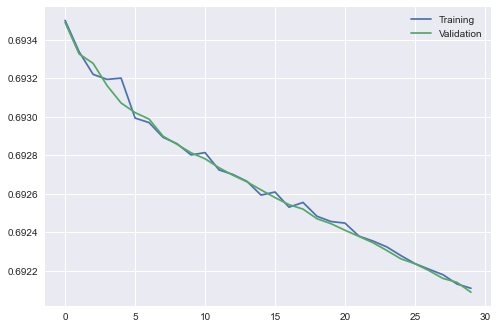


 LeakyReLU  achieved best F1 score after  29  epochs.

Evaluation Results
_________________________________
Predicted 2183 / 3601 correctly
Mean Loss: 0.69 
Recall: 81.50%
Precision: 57.57%
Accuracy: 60.62%
Macro Averaged F1-score: 58.79%
_________________________________
Training loss - validation loss average difference:  2.566205856462389e-05


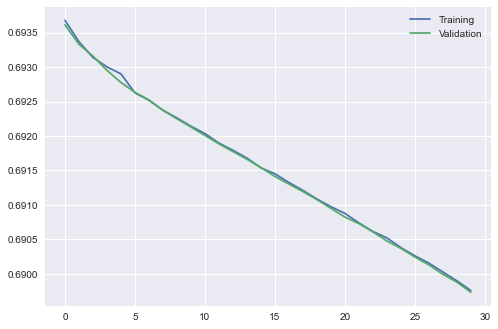


 ELU  achieved best F1 score after  28  epochs.

Evaluation Results
_________________________________
Predicted 2427 / 3601 correctly
Mean Loss: 0.69 
Recall: 62.83%
Precision: 69.27%
Accuracy: 67.40%
Macro Averaged F1-score: 67.33%
_________________________________
Training loss - validation loss average difference:  3.040806101640703e-05


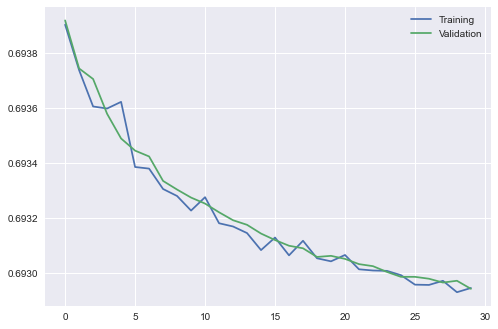


 SiLU  achieved best F1 score after  27  epochs.

Evaluation Results
_________________________________
Predicted 1807 / 3601 correctly
Mean Loss: 0.69 
Recall: 99.94%
Precision: 50.15%
Accuracy: 50.18%
Macro Averaged F1-score: 33.56%
_________________________________


/Users/themis/opt/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/functional.py:2102: UserWarning: The operator 'aten::hardswish' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish(input)


Training loss - validation loss average difference:  3.0409615394244582e-05


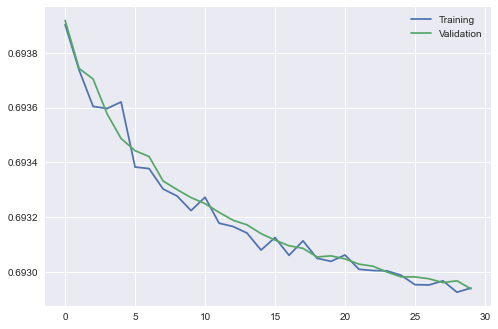


 Hardswish  achieved best F1 score after  27  epochs.

Evaluation Results
_________________________________
Predicted 1808 / 3601 correctly
Mean Loss: 0.69 
Recall: 99.94%
Precision: 50.17%
Accuracy: 50.21%
Macro Averaged F1-score: 33.62%
_________________________________
Training loss - validation loss average difference:  2.0792195786071647e-05


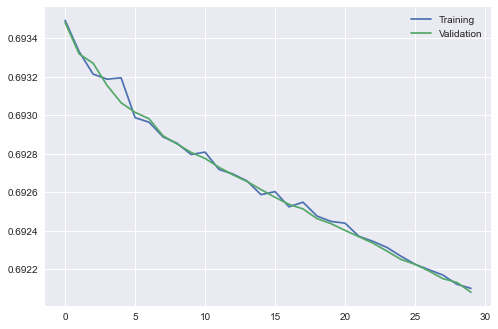


 ReLU6  achieved best F1 score after  29  epochs.

Evaluation Results
_________________________________
Predicted 2193 / 3601 correctly
Mean Loss: 0.69 
Recall: 81.77%
Precision: 57.77%
Accuracy: 60.90%
Macro Averaged F1-score: 59.08%
_________________________________
Training loss - validation loss average difference:  2.0917114541363356e-05


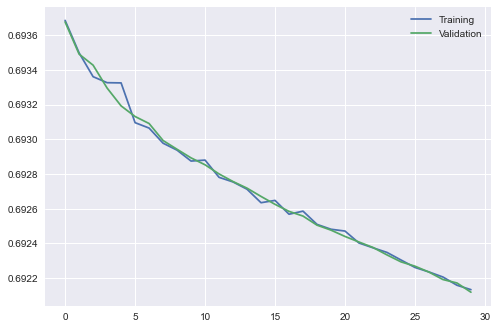


 PReLU  achieved best F1 score after  29  epochs.

Evaluation Results
_________________________________
Predicted 2184 / 3601 correctly
Mean Loss: 0.69 
Recall: 80.17%
Precision: 57.74%
Accuracy: 60.65%
Macro Averaged F1-score: 59.06%
_________________________________
          0      1          2      3      4          5      6      7
0             ReLU  LeakyReLU    ELU   SiLU  Hardswish  ReLU6  PReLU
1  Accuracy   60.9      60.62   67.4  50.18      50.21   60.9  60.65
2  F1-score  59.08      58.79  67.33  33.56      33.62  59.08  59.06
3      Time  19.56      19.34  19.82  20.15      30.12   19.8  21.63


In [100]:
# Hyperparameters
learning_rate = 2e-3
epochs= 30

activations = [    
                nn.ReLU
                , nn.LeakyReLU
                , nn.ELU
                , nn.SiLU
                , nn.Hardswish
                , nn.ReLU6
                , nn.PReLU
            ]

Results = np.empty(shape=(4, 8), dtype=object)
Results[0,0] = ""
Results[1,0] = "Accuracy"
Results[2,0] = "F1-score"
Results[3,0] = "Time"

for i, activationFunction in enumerate(activations):
    Results[0,i+1] = activationFunction.__name__

    # Seed libraries
    seedTorch()
    startTime = time.time()

    # Initialise Neural Network
    model = FeedforwardNeuralNetwork3(activationFunction).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    lossfunc = nn.CrossEntropyLoss()

    # Train model and find the best epoch
    bestepoch = optimalModel(device, model, epochs, train_dataloader, val_dataloader, optimizer, lossfunc, False)

    print("\n",activationFunction.__name__," achieved best F1 score after ", bestepoch, " epochs.")

    seedTorch()

    # Use the best model found before
    model = FeedforwardNeuralNetwork3(activationFunction).to(device)
    model.load_state_dict(torch.load('./bestModel.pt'))
    model = model.to(device)

    # Evaluate on this model
    _, _, _, meanloss, acura, f1, _, _ = evaluationFunction(test_dataloader, model, lossfunc, device, True)

    endTime = time.time()
    took = endTime - startTime

    Results[1,i+1] = float("{:.2f}".format(acura))
    Results[2,i+1] = float("{:.2f}".format(f1))
    Results[3,i+1] = float("{:.2f}".format(took))

with pd.option_context('expand_frame_repr', False):
    print(DataFrame(Results))

The ELU activation function appears to be the best performer in terms of F1-Score and accuracy, while the ReLU 'family' of activation functions performs similarly. From the learning curves, it seems that ReLU does not overfit after all the epochs and also has a recall of 80%, which is important for this task.

However, ELU, despite having better metrics, never allows its values to reach zero like ReLU does. This characteristic might be less useful during sentiment analysis. To test this suspicion, I will conduct further experiments using these two activation functions.

### F1-Score Learning Curves
To automate the creation of learning curves for the F1 score (since optimal model plots for the mean loss), I have defined the function below, which trains the model and then plots the learning curves for both the training and validation sets.

In [106]:
# Function producing learning curves through epochs
def learningCurve(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False, scheduler=None):

    train_f1_scores = []
    valid_f1_scores = []
    
    # For each epoch
    for epoch in range(epochs):
        
        # Train the model
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display)

        _, _, _, _, _, f1_train, _, _ = evaluationFunction(traindataloader, model, lossfunc, device, display)

        # Evaluation
        _, _, _, _, _, f1_eval, _, _ = evaluationFunction(test_dataloader, model, lossfunc, device, display)
    
        train_f1_scores.append(f1_train)
        valid_f1_scores.append(f1_eval)
        
        # If there is a scheduler step here
        if (scheduler):
            if (scheduler.__class__.__name__=='ReduceLROnPlateau'):
                scheduler.step(meanloss)
            else:
                scheduler.step()

    x = list(range(0, len(train_f1_scores)))
    plt.style.use('seaborn')
    plt.plot(x, train_f1_scores, linestyle="-", label="Training")
    plt.plot(x, valid_f1_scores, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

Testing this function with the ELU activation function below.

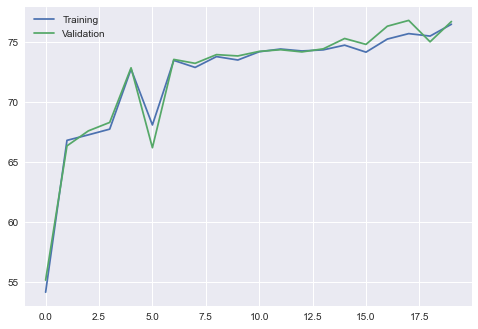

In [107]:
# Υπερπαράμετροι
learning_rate = 2e-2
epochs= 20
activationFunction = nn.ELU

# Αρχικοποίηση νευρωνικού
model = FeedforwardNeuralNetwork3(activationFunction).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()

# Train the network and plot a learning curve
learningCurve(device, model, epochs, train_dataloader, test_dataloader, optimizer, lossfunc)

Something that was apparent from the previous test is also prevalent here that with ELU there is not a consistent performance in the training and validation sets. The F1-score is jumping around in each epoch with the difference between them varying a lot.

Below I'll test the same model with ReLU and the same parameters.

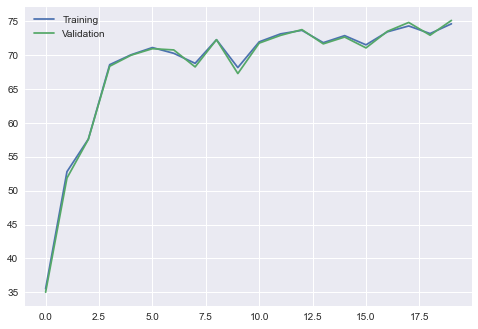

In [108]:
# Hyperparameters
learning_rate = 2e-2
epochs= 20
activationFunction = nn.ReLU

# Model initialisation
model = FeedforwardNeuralNetwork3(activationFunction).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()

# Train the network and plot a learning curve
learningCurve(device, model, epochs, train_dataloader, test_dataloader, optimizer, lossfunc)

It is obvious from the learning curve of the F1-Score that ReLU makes the model quite more stable. The difference between training and validation sets is always quite close which shows that the model is neither overfitting or underfitting on the data. So I will be using this one while tuning the hyperparameters of the model.

## Hyperparameter Optimization

For the hyperparameter as well as the optimizers I will be using Optuna. Initially I'll create the dataset classes.

In [109]:
# Dataset class for optuna
class optunaDataset(Dataset):

    def __init__(self, xdata, ydata):
        self.x = torch.tensor(xdata, dtype=torch.float)
        self.y = torch.tensor(ydata, dtype=torch.long)
        self.samples = ydata.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [110]:
# Datasets
OptunaTrainDataset = optunaDataset(X_train_means, indexed_labels_train)
OptunaValidDataset = optunaDataset(X_val_means, indexed_labels_val)

### Optuna Search

- As an initial search space I will experiment with 1 to 5 number of layers. I think anything over five is too much since the input dimension is only 300 and it will lead to vanishing gradients. The number of nodes will be in the range of 2 to 512.

- Between each linear layer I'll have ReLU and a Dropout of between 0.01 and 0.3. While the learning rate will have a large range to play with. From the optimizers I selected Adam, SGD, RMSProp and Adagrad to be trialed.

- I'll train the model for 30 epochs which seemed to be the point that the model was starting to diverge in my previous experiments. I also set the details to be printed as was suggested in the documentation of Optuna, with the pruned trials as well as the best parameters of the model found.

In [113]:
# The initial constants
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'
DEVICE = torch.device(device=device)
BATCHSIZE = 512
CLASSES = 2
EPOCHS = 30

def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []

    # In our case 300 which is the embedding vector dimension
    in_features = 300
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 2, 512)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.01, 0.3)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))

    return nn.Sequential(*layers)

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD", "Adagrad"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    lossfunc = nn.CrossEntropyLoss()

    # Corresponding dataloaders
    train_loader = DataLoader(dataset=OptunaTrainDataset, batch_size=BATCHSIZE, shuffle=True)
    valid_loader = DataLoader(dataset=OptunaValidDataset, batch_size=BATCHSIZE, shuffle=True)

    # Training of the model
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = lossfunc(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")

    # With this timeout it stops after 1 hour
    study.optimize(objective, n_trials=100, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 

[I 2022-12-14 19:20:38,820] A new study created in memory with name: no-name-1792963b-316a-4a75-82a3-2f2a22c1d27b
[I 2022-12-14 19:21:13,299] Trial 0 finished with value: 0.4996667407242835 and parameters: {'n_layers': 5, 'n_units_l0': 490, 'dropout_l0': 0.03947876127256386, 'n_units_l1': 506, 'dropout_l1': 0.0778083680278872, 'n_units_l2': 146, 'dropout_l2': 0.10549237630528802, 'n_units_l3': 188, 'dropout_l3': 0.09740397246498748, 'n_units_l4': 127, 'dropout_l4': 0.01163668325591377, 'optimizer': 'SGD', 'lr': 0.0003360861296484915}. Best is trial 0 with value: 0.4996667407242835.
[I 2022-12-14 19:21:34,057] Trial 1 finished with value: 0.8164852255054432 and parameters: {'n_layers': 1, 'n_units_l0': 219, 'dropout_l0': 0.17683821768644448, 'optimizer': 'Adagrad', 'lr': 0.0011964457468239}. Best is trial 1 with value: 0.8164852255054432.
[I 2022-12-14 19:21:58,590] Trial 2 finished with value: 0.8295934236836259 and parameters: {'n_layers': 2, 'n_units_l0': 333, 'dropout_l0': 0.1586499

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  74
  Number of complete trials:  26
Best trial:
  Value:  0.838258164852255
  Params: 
    n_layers: 2
    n_units_l0: 43
    dropout_l0: 0.0943807502784559
    n_units_l1: 351
    dropout_l1: 0.08509963319458344
    optimizer: Adam
    lr: 0.00034039943321835487


The best optimizer was Adam and a Neural Network of 2 layers. I will use the parameters found on a later test, but first I'll experiment further by setting the maximum layers to 3 which looking at most of Optuna's trials the best performing ones were under 4 layers.

Also, I'll have wider range of nodes, learning rate and Dropout percentages to see if with the Adam optimizer alone some better hyperparameters can be found.

In [115]:
# The initial constants
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'
DEVICE = torch.device(device=device)
BATCHSIZE = 256
CLASSES = 2
EPOCHS = 30

def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    # In our case 300 which is the embedding vector dimension
    in_features = 300
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 2, 1024)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.01, 0.4)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))

    return nn.Sequential(*layers)

def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])
    lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    lossfunc = nn.CrossEntropyLoss()

    # Corresponding dataloaders
    train_loader = DataLoader(dataset=OptunaTrainDataset, batch_size=BATCHSIZE, shuffle=True)
    valid_loader = DataLoader(dataset=OptunaValidDataset, batch_size=BATCHSIZE, shuffle=True)

    # Training of the model
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = lossfunc(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")

    # With this timeout it stops after 1 hour
    study.optimize(objective, n_trials=80, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 

[I 2022-12-14 19:58:36,749] A new study created in memory with name: no-name-a454ac85-f1df-42ba-9bcf-62b2d1121e91
[I 2022-12-14 19:59:36,952] Trial 0 finished with value: 0.7758275938680294 and parameters: {'n_layers': 2, 'n_units_l0': 910, 'dropout_l0': 0.03609287135235414, 'n_units_l1': 292, 'dropout_l1': 0.012748773837711131, 'optimizer': 'Adam', 'lr': 2.2229719193147782e-06}. Best is trial 0 with value: 0.7758275938680294.
[I 2022-12-14 20:00:51,362] Trial 1 finished with value: 0.8053765829815597 and parameters: {'n_layers': 3, 'n_units_l0': 280, 'dropout_l0': 0.23157398871031662, 'n_units_l1': 514, 'dropout_l1': 0.07023641923705883, 'n_units_l2': 777, 'dropout_l2': 0.17416762135034428, 'optimizer': 'Adam', 'lr': 0.08369993372173054}. Best is trial 1 with value: 0.8053765829815597.
[I 2022-12-14 20:01:32,931] Trial 2 finished with value: 0.7920462119528994 and parameters: {'n_layers': 1, 'n_units_l0': 819, 'dropout_l0': 0.16885906757374142, 'optimizer': 'Adam', 'lr': 7.26661135132

Study statistics: 
  Number of finished trials:  80
  Number of pruned trials:  60
  Number of complete trials:  20
Best trial:
  Value:  0.8433681404132415
  Params: 
    n_layers: 1
    n_units_l0: 710
    dropout_l0: 0.3842182035126469
    optimizer: Adam
    lr: 0.0037334747114782345


The performance of the best model was slightly better here and with only one linear layer and a large dropout of 38%. So I'll be testing these two models on the test set to see which one performs better. Initially I'll define below the Neural Network with the hyperparameters of the first Optuna search.

In [118]:
# Feedforward Neural Network
class FeedforwardNeuralNetwork4(nn.Module):
    
    def __init__(self):
        super(FeedforwardNeuralNetwork4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(300, 43),
            nn.ReLU(),
            nn.Dropout(0.0943807502784559),
            nn.Linear(43, 351),
            nn.ReLU(),
            nn.Dropout(0.08509963319458344),
            nn.Linear(351, 2)
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

And training this model for 100 epochs, while saving the best model and using this on the test set.

Training loss - validation loss average difference:  0.061757019086878404


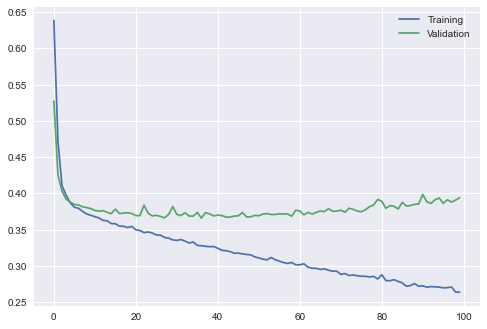

Best F1 score after  69  epochs.

Evaluation Results
_________________________________
Predicted 3059 / 3601 correctly
Mean Loss: 0.33 
Recall: 86.09%
Precision: 84.23%
Accuracy: 84.95%
Macro Averaged F1-score: 84.95%
_________________________________


In [119]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

seedTorch()

# Hyperparameters
epochs= 100
learning_rate = 0.00034039943321835487
dataloader= train_dataloader

# Model initialisation and Training here 1 since it's only one vector and 300 dimension
model = FeedforwardNeuralNetwork4().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
best_epoch = optimalModel(device, model, epochs, dataloader, val_dataloader, optimizer, lossfunc)

print("Best F1 score after ", best_epoch, " epochs.")

# Αρχικοποίω και φορτώνω το model με το καλύτερο στιγμιότυπο
seedTorch()
model = FeedforwardNeuralNetwork4().to(device)
model.load_state_dict(torch.load('./bestModel.pt'))
model = model.to(device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)

With an accuracy and F1-Score of close to 85% it is obvious that with these hyperparameters the model has the best peformance up till now. Though it is accurate if we see the plotting of the learning curve of the mean loss after a few epochs as is expected it tends to overfit to the train set. This can also be observed by looking at the epoch that the best F1-score was achieved for the validation set which was 69 and was the one used to evaluate the test set.

Below I'll define the Network with the optimal hyperparameters found from the second search.

In [121]:
# Feedforward Neural Network with custom activation function
class FeedforwardNeuralNetwork5(nn.Module):
    
    def __init__(self):
        super(FeedforwardNeuralNetwork5, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(300, 710),
            nn.ReLU(),
            nn.Dropout(0.3842182035126469),
            nn.Linear(710, 2)
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

This has only one intermediate layer of 710 nodes and a Dropout of 0.38. I'll test this below again for 100 epochs.

Training loss - validation loss average difference:  0.1398283677373529


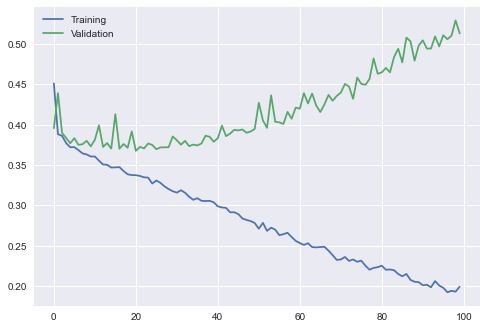

Best F1 score after  52  epochs.

Evaluation Results
_________________________________
Predicted 3066 / 3601 correctly
Mean Loss: 0.34 
Recall: 85.10%
Precision: 85.24%
Accuracy: 85.14%
Macro Averaged F1-score: 85.14%
_________________________________


In [122]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

seedTorch()

# Hyperparameters
epochs= 100
learning_rate = 0.0037334747114782345
dataloader= train_dataloader

# Model initialisation and Training here 1 since it's only one vector and 300 dimension
model = FeedforwardNeuralNetwork5().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
best_epoch = optimalModel(device, model, epochs, dataloader, val_dataloader, optimizer, lossfunc)

print("Best F1 score after ", best_epoch, " epochs.")

# Αρχικοποίω και φορτώνω το model με το καλύτερο στιγμιότυπο
seedTorch()
model = FeedforwardNeuralNetwork5().to(device)
model.load_state_dict(torch.load('./bestModel.pt'))
model = model.to(device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)

This network performs significantly better with all metrics exceeding 85%, and the best model is achieved much earlier, after only 52 epochs. This outcome is somewhat expected since the network consists of only one layer, and the inclusion of dropout helps prevent overfitting in the early stages. 

However, the interesting observation from the learning curve is that, as the epochs progress, the mean loss of the validation set begins to regress compared to the training set. This indicates that the model starts to overfit after a certain point.

To emphasize this point, I will redefine the model below, adding a sigmoid layer at the end. This addition will enable the plotting of the ROC curve, which requires probabilities of the positive class.

In [123]:
# Feedforward Neural Network with custom activation function
class FeedforwardNeuralNetwork6(nn.Module):
    
    def __init__(self):
        super(FeedforwardNeuralNetwork6, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(300, 710),
            nn.ReLU(),
            nn.Dropout(0.3842182035126469),
            nn.Linear(710, 2),
            nn.Sigmoid()
        )

    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

I'll train the model for 80 epochs this time, so before the point that it starts to overfit too much.

Training loss - validation loss average difference:  0.028480174640814475


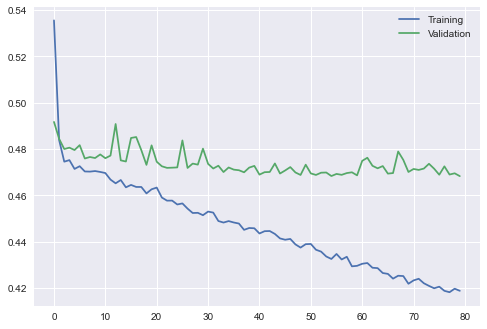

Best F1 score after  79  epochs.

Evaluation Results
_________________________________
Predicted 3072 / 3601 correctly
Mean Loss: 0.45 
Recall: 85.26%
Precision: 85.41%
Accuracy: 85.31%
Macro Averaged F1-score: 85.31%
_________________________________


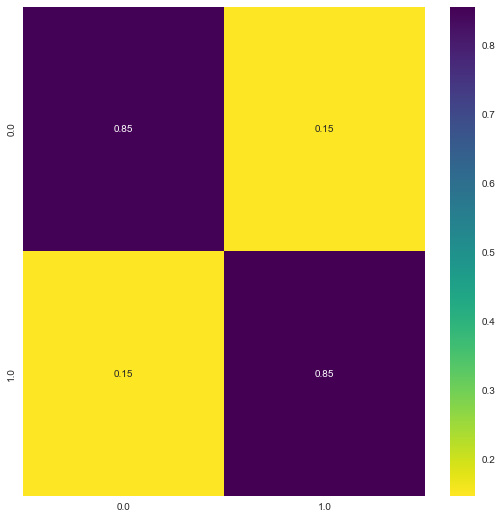

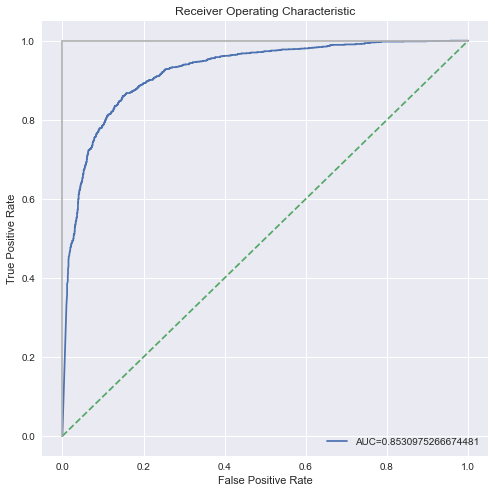

In [124]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

seedTorch()
# Hyperparameters
epochs= 80
learning_rate = 0.0037334747114782345
dataloader= train_dataloader

# Model initialisation and Training here 1 since it's only one vector and 300 dimension
model = FeedforwardNeuralNetwork6().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lossfunc = nn.CrossEntropyLoss()
best_epoch = optimalModel(device, model, epochs, dataloader, val_dataloader, optimizer, lossfunc)

print("Best F1 score after ", best_epoch, " epochs.")

# Initialise and load the model with the best score
seedTorch()
model = FeedforwardNeuralNetwork6().to(device)
model.load_state_dict(torch.load('./bestModel.pt'))
model = model.to(device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The model also performs well with fewer epochs in the validation set, and we can observe that the divergence is not significant in the earlier stages of training. Additionally, the ROC curve, which is positioned close to the top left corner, indicates that the model exhibits high sensitivity and true positive rates across various thresholds. This observation is further supported by the AUC value of 0.853.

### Test Set Evaluation

To evaluate the final model using a test set, I have defined the function below. It takes the path of the test set as a parameter, trains the model, and makes predictions for the test set. The function returns the predictions as a vector and also prints the evaluation metrics, including a confusion matrix and the ROC curve.

In [126]:
# Perform sentiment analysis with the optimal model
def sentiment_network(testdata):

    # Reading the file
    test_df = pd.read_csv(testdata, sep = '\t')

    # Classify the test ratings as positive and negative
    X_test = test_df['review']
    Y_test = test_df[['rating']].copy()
    Y_test.loc[Y_test['rating'] <= 5, 'rating'] = 0
    Y_test.loc[Y_test['rating'] > 5, 'rating'] = 1

    # Unique returns the mapping sorted
    labelsMapping, indexed_labels_test = np.unique(Y_test['rating'], return_inverse=True)

    # Prepare the vectors
    X_test = prepare_data(X_test, word_dictionary=word_dictionary_300d)
    X_test_means = sentence_vectors(X_test, 300) 

    # Datasets
    testDataset = customDataset(X_test_means, indexed_labels_test)

    # Corresponding dataloaders
    test_dataloader = DataLoader(dataset=testDataset, batch_size=512, shuffle=False)

    # Resetting the model with the best performance
    seedTorch()
    model = FeedforwardNeuralNetwork6().to(device)
    model.load_state_dict(torch.load('./bestModel.pt'))
    model = model.to(device)

    # Evaluate on the test set and print confusion matrix and roc curve
    trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
    confusionMatrix(trues, preds)
    roc_auc = rocCurve(trues, preds, probs)

    return roc_auc

To run the model, simply add the path of your file below and execute the cell.

In [128]:
predictions = sentiment_network(testdata="./yourfile.csv")